# Notebook to check the DR9 SV imaging

In [1]:
import os 
import glob
import h5py
import ephem
import fitsio
import numpy as np 
import pylab as pl

from desimodel.io import load_tiles
from astropy.time import Time, TimeDelta
from astropy.table import Table
from desimodel.footprint import is_point_in_desi
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
# local directory with data
dat_dir    = '/global/cfs/cdirs/desi/users/chahah/'

# Read parent DESI tile

In [3]:
# pick the rest of the tiles from desi-tiles.fits far from the selected tiles 
desi_tiles = load_tiles(onlydesi=False)

imaging    = Table(desi_tiles[desi_tiles['IN_IMAGING'] == 1], copy=True)
imaging    = imaging[imaging['PASS'] == 5]['RA', 'DEC']

desi_tiles = desi_tiles[desi_tiles['PASS'] == 5]
desi_tiles = desi_tiles[desi_tiles['IN_DESI'] == 1]

# Read moon positions starting Jan 1, 2020

In [4]:
def get_moons():
    moon  = ephem.Moon()

    start = Time('2020-01-01', format='iso')
    moons = []

    for day in range(365):
        night = start + day * TimeDelta(1., format='jd')
        night = night.isot.replace('-', '/').replace('T',' ').split('.')[0]
    
        moon.compute(night)
        moons.append([moon.ra, moon.dec])
    
    moons       = np.array(moons)
    moons[:,0] *= 180. / np.pi
    moons[:,1] *= 180.
    
    return moons

In [5]:
moons = get_moons()

# Lets read in the potential SV regions
starting with
## Abell cluster fields within DESI

In [6]:
abell = Table.read('../../dat/abell.dat', format='ascii', names=['Name', 'RA', 'DEC']) 
isin = is_point_in_desi(imaging, abell['RA'], abell['DEC'], return_tile_index=False)
print('%i of %i Abell fields are within the DESI footprint' % (np.sum(isin), len(isin)))

24 of 29 Abell fields are within the DESI footprint


In [7]:
abell = abell[isin]

## DES supernovae fields

In [8]:
des_sn = Table.read('../../dat/des-supernovae.dat', format='ascii', names=['FIELD', 'RA', 'DEC', 'DEPTH']) 

In [9]:
des_sn

FIELD,RA,DEC,DEPTH
str2,float64,float64,str7
X1,34.4757,-4.9295,shallow
X2,35.6645,-6.4121,shallow
X3,36.45,-4.6,deep
S1,42.82,0.0,shallow
S2,41.1944,-0.9884,shallow


## SV fields in Table 2 of SV document
These are fields that span the three imaging catalogs, regions with overlapping imaging, regions with truth tables, bad seeing conditions, etc. 

In [10]:
sv_regions = Table.read('../../dat/sv_fields.dat', format='ascii') 

In [11]:
sv_regions

col1,col2,col3,col4,col5
str3,float64,float64,float64,float64
ngc,187.0,191.0,61.0,63.0
ngc,210.0,220.0,50.0,55.0
ngc,215.0,230.0,41.0,46.0
ngc,260.0,280.0,60.0,70.0
ngc,129.0,141.0,-2.0,3.0
ngc,149.0,151.0,1.2,3.2
ngc,174.0,186.0,-3.0,2.0
ngc,211.0,224.0,-2.0,3.0
sgc,-5.0,5.0,15.0,20.0


In [12]:
def plot_context(sub, label=True): 
    # DESI tiles
    sub.scatter(desi_tiles['RA'], desi_tiles['DEC'], s=5, alpha=0.5, c='k')
    sub.scatter(imaging['RA'], imaging['DEC'], s=5, alpha=0.1, c='k')

    # Moon positions
    sub.scatter(moons[:,0], moons[:,1], c='C1', alpha=0.8, s=2, label=[None, 'moon'][label])

    # Abell clusters
    sub.scatter(abell['RA'], abell['DEC'], c='C2', s=15, label=[None, 'Abell'][label])
    
    # DES SN fields
    sub.scatter(des_sn['RA'], des_sn['DEC'], c='C3', s=15, label=[None, 'DES SN'][label], zorder=10)
    
    # SV regions
    if label: 
        region = patches.Rectangle((0,0),0,0, linewidth=1, facecolor='C0', alpha=0.5, label='SV fields')
        sub.add_patch(region) 
    for sv_region in sv_regions: 
        ra_min, ra_max, dec_min, dec_max = sv_region[1], sv_region[2], sv_region[3], sv_region[4]
        region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), linewidth=1, facecolor='C0', alpha=0.5)
        sub.add_patch(region) 
    return None

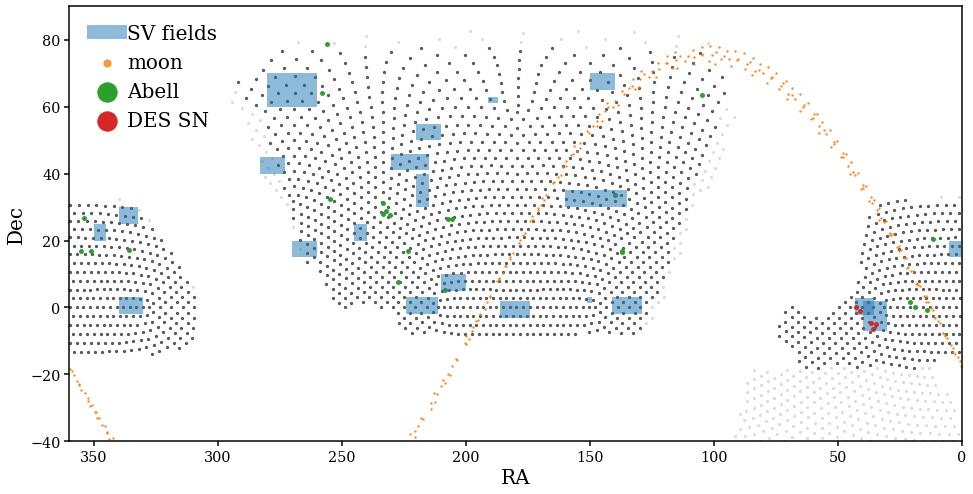

In [13]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=True)

sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
sub.legend(loc='upper left', fontsize=20, handletextpad=0., markerscale=5)

# Regions we want *outside* of proposed SV fields

In [14]:
omitted_regions = {}
omitted_regions['PRIMUS-COSMOS']     = np.array([149.6, 150.7, 1.8, 2.9])
omitted_regions['PRIMUS-CDFS-SWIRE'] = np.array([51.8, 54.4, -29.7, -28.0])

In [15]:
def plot_omitted(sub, label=False): 
    # omitted region
    for i, reg in enumerate(omitted_regions.keys()): 
        ra_min, ra_max, dec_min, dec_max = omitted_regions[reg]
        region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), facecolor='r', label=[None, reg][label])
        sub.add_patch(region)     
    return None

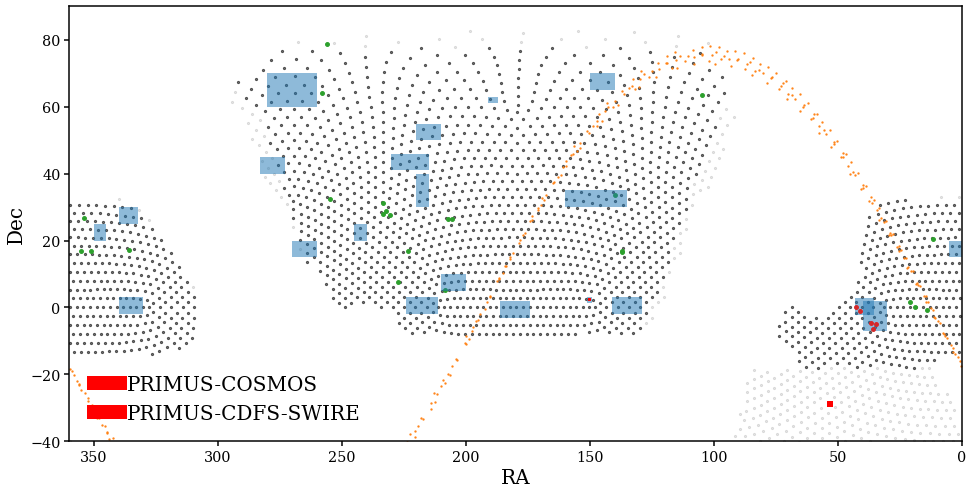

In [16]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)
plot_omitted(sub, label=True)

sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
sub.legend(loc='lower left', fontsize=20, handletextpad=0., markerscale=5)

Lets compare the DR9 SV footprint to the old BGS SV fields

In [17]:
sv_old = fitsio.read(os.path.join(dat_dir, 'BGS_SV_30_3x_superset60_Sep2019.fits')) 

(-40.0, 90.0)

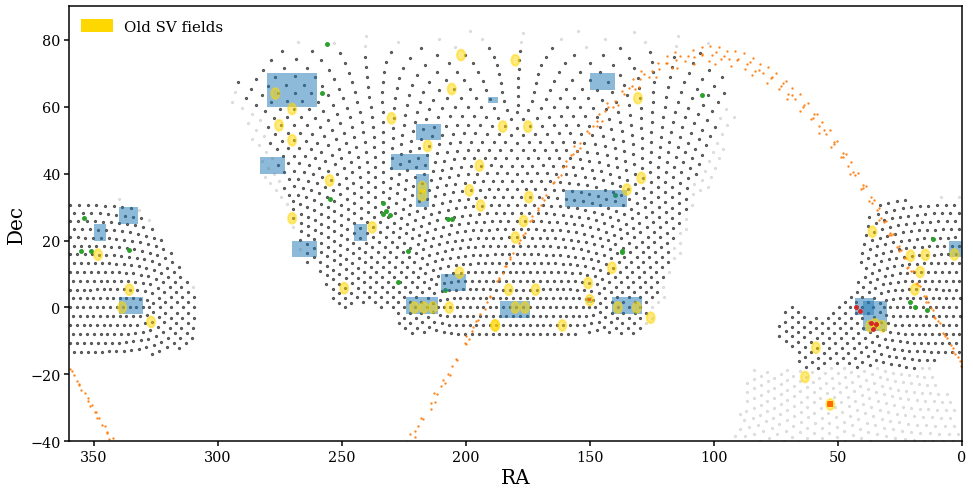

In [18]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)

plot_omitted(sub, label=False)

for i in range(len(sv_old['RA'])): 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='gold', facecolor='gold', linewidth=2, alpha=0.5) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='gold', facecolor='gold', linewidth=2, label='Old SV fields') 
sub.add_patch(circ) 
        
sub.legend(loc='upper left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

Overall, there's very little overlap with the DR9 SV fields. First, lets keep all the old tiles that are in the SV regions and the PRIMUS regions.

In [19]:
# keep fields that already fall into regions 
print('out of %i fields' % len(sv_old['RA']))

keep = np.zeros(len(sv_old['RA'])).astype(bool) 

for sv_region in sv_regions: 
    ra_min, ra_max, dec_min, dec_max = sv_region[1], sv_region[2], sv_region[3], sv_region[4]
    inkeep = (
            (sv_old['RA'] - 1.6275 > ra_min) & (sv_old['RA'] + 1.6275 < ra_max) & 
            (sv_old['DEC'] - 1.6275 > dec_min) & (sv_old['DEC'] + 1.6275 < dec_max)
            )    
    keep = keep | inkeep
print('keeping %i previous fields that fall in SV regions' % np.sum(keep))

for reg in omitted_regions.keys(): 
    ra_min, ra_max, dec_min, dec_max = omitted_regions[reg]
    inkeep = (
            (sv_old['RA'] > ra_min) & (sv_old['RA'] < ra_max) & 
            (sv_old['DEC'] > dec_min) & (sv_old['DEC'] < dec_max)
            ) 
    keep = keep | inkeep 
print('keeping %i previous fields including omitted regions' % np.sum(keep))

out of 60 fields
keeping 11 previous fields that fall in SV regions
keeping 13 previous fields including omitted regions


(-40.0, 90.0)

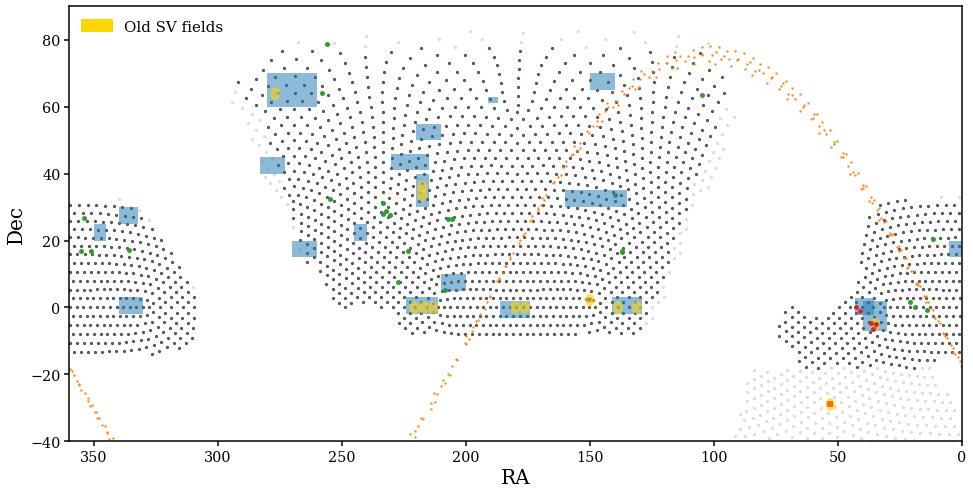

In [20]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)

plot_omitted(sub, label=False)

for i in np.arange(len(sv_old['RA']))[keep]: 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='gold', facecolor='gold', linewidth=2, alpha=0.5) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='gold', facecolor='gold', linewidth=2, label='Old SV fields') 
sub.add_patch(circ) 
        
sub.legend(loc='upper left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

Now lets put as many new BGS SV tiles in the SV fields

In [21]:
ra_new, dec_new = [], [] 
for i, sv_region in enumerate(sv_regions): 
    ra_min, ra_max, dec_min, dec_max = sv_region[1], sv_region[2], sv_region[3], sv_region[4]
   
    if i == 3: 
        inregion = ((desi_tiles['RA'] > ra_min+1.63) & (desi_tiles['RA'] < ra_max-1.63) & 
                    (desi_tiles['DEC'] > dec_min+1.63) & (desi_tiles['DEC'] < dec_max-1.63))        
        notnearold = np.zeros(np.sum(inregion)).astype(bool)
        for ii, i in enumerate(np.arange(len(desi_tiles['RA']))[inregion]):
            if (np.sqrt((desi_tiles['RA'][i] - sv_old['RA'][50])**2 + (desi_tiles['DEC'][i] - sv_old['DEC'][50])**2) > 1.63): 
                notnearold[ii] = True
        ra_new.append(desi_tiles['RA'][inregion][notnearold])
        dec_new.append(desi_tiles['DEC'][inregion][notnearold])
        
    elif i == 9: # s82, G02, DEEP2, XMM-LSS
        i_ra = np.floor(((ra_max - ra_min) - 2. * 1.63) / (2.5*1.63))
        dra = (ra_max - ra_min) / (i_ra+1)
        _ra = [ra_min + dra * (i+0.5) for i in range(int(i_ra)+1)]
        _dec = [0.25*dec_min + 0.75*dec_max  for _ in _ra]
        ra_new.append(_ra)
        dec_new.append(_dec) 
    elif i == 11: 
        dra = (ra_max - ra_min) / 6
        _ra = [ra_min + dra * (i+0.5) for i in range(6)]
        ra_new.append(_ra)
        dec_new.append([0.5*(dec_min + dec_max) for _ in _ra]) 
    elif i == 12: # BASS+MzLS and DEES, s82, HSC
        ra_new.append([ra_max-1.63])
        dec_new.append([0.5*(dec_min + dec_max)])
    elif i == 4: # GAMA 09
        ra_new.append([0.5 * (ra_min + ra_max)])
        dec_new.append([0.5 * (dec_min + dec_max)])
    elif i == 6: # GAMA 12
        ra_new.append([ra_max - 1.63])
        dec_new.append([0.5*(dec_min + dec_max)])
    elif i == 8: 
        ra_new.append([0.5 * (ra_min + ra_max)])
        dec_new.append([0.5 * (dec_min + dec_max)])
    else: 
        inregion = (
                (sv_old['RA'] - 1.6275 > ra_min) & (sv_old['RA'] + 1.6275 < ra_max) & 
                (sv_old['DEC'] - 1.6275 > dec_min) & (sv_old['DEC'] + 1.6275 < dec_max)
                )   
        if np.sum(inregion) == 0:
            i_ra = np.floor((ra_max - ra_min) / (2*1.63) - 1)
            if i_ra > 0: 
                dra = (ra_max - ra_min) / (i_ra+1)
                _ra = [ra_min + dra * (i+0.5) for i in range(int(i_ra)+1)]
                ra_new.append(_ra)
                dec_new.append([0.5*(dec_min + dec_max) for _ in _ra]) 
            else: 
                ra_new.append([0.5*(ra_min + ra_max)])
                dec_new.append([0.5*(dec_min + dec_max)])

# Abell cluster
ra_new.append([233.])
dec_new.append([28.5])
                
ra_new = np.concatenate(ra_new)
dec_new = np.concatenate(dec_new)
print('%i new SV fields in DR9SV regions' %  len(ra_new)) 
print('%i total tiles assigned so far' % (np.sum(keep) + len(ra_new)))

47 new SV fields in DR9SV regions
60 total tiles assigned so far


(-40.0, 90.0)

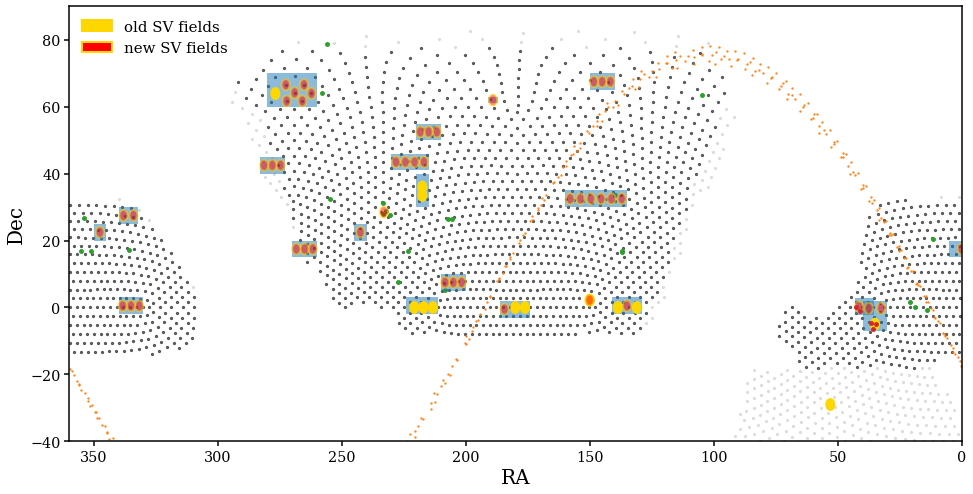

In [22]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)

plot_omitted(sub, label=False)

for i in np.arange(len(sv_old['RA']))[keep]: 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='gold', facecolor='gold', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='gold', facecolor='gold', linewidth=2, label='old SV fields') 
sub.add_patch(circ) 

for i in np.arange(len(ra_new)): 
    circ = patches.Circle((ra_new[i], dec_new[i]), 
                          radius=1.6275, edgecolor='gold', facecolor='r', linewidth=2, alpha=0.5) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='gold', facecolor='r', linewidth=2, label='new SV fields') 
sub.add_patch(circ) 
        
sub.legend(loc='upper left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

In [23]:
sv_new = sv_old.copy() 

for i in range(np.sum(~keep)): 
    sv_new['RA'][~keep][i] = ra_new[i] 
    sv_new['DEC'][~keep][i] = dec_new[i] 

In [24]:
print('Total number of tiles: {:d}'.format(len(sv_new)))

Total number of tiles: 60


In [25]:
fitsio.write(os.path.join(dat_dir, 'BGS_SV_30_3x_superset60_Dec2020.fits'), sv_new, clobber=True)

In [26]:
! ./../../bin/up --tiles $dat_dir"BGS_SV_30_3x_superset60_Dec2020.fits" --firstday 20201201 --lastday 20210102 --outdir $dat_dir --numproc 12

Traceback (most recent call last):
  File "./../../bin/up", line 26, in <module>
    from    whatprogram              import  whatprogram
ModuleNotFoundError: No module named 'whatprogram'


In [81]:
sv_up   = fitsio.read(os.path.join(out_dir, 'up-BGS_SV_30_3x_superset60_Apr2020v2.fits'))

In [84]:
visible = (sv_up['DECEMBER'][:,0] > 0.0) & (sv_up['DECEMBER'][:,2] > 0.0)
sv_up   = sv_up[visible]

print('%i out of %i are visibile' % (np.sum(visible), len(visible)))

50 60


In [ ]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)

plot_omitted(sub, label=False)

for i in np.arange(len(sv_new['RA'])): 
    circ = patches.Circle((sv_new['RA'][i], sv_new['DEC'][i]), 
                          radius=1.6275, edgecolor='gold', facecolor='gold', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='gold', facecolor='gold', linewidth=2, label='new SV fields') 
sub.add_patch(circ) 

for i in np.arange(len(sv_new['RA']))[visible]: 
    circ = patches.Circle((sv_new['RA'][i], sv_new['DEC'][i]), 
                          radius=1.6275, edgecolor='gold', facecolor='r', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='gold', facecolor='r', linewidth=2, label='visible SV fields') 
sub.add_patch(circ) 

sub.legend(loc='upper left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

# Done.